## Load Data

In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, mean_squared_error
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import time

#  Import and read the data
application_df = pd.read_csv("../Resources/IMDB_OMDB_FINAL.csv")
print(f'dataframe length: {len(application_df)}')
application_df.head()

Using TensorFlow backend
dataframe length: 224162


,Unnamed: 0,tconst,averageRating,numVotes,isAdult,startYear,runtimeMinutes,genres,Movie,OMDB_Title,...,OMDB_Metascore,OMDB_imdbRating,OMDB_imdbVotes,OMDB_BoxOffice,OMDB_Production,ReleaseYear,ReleaseMonth,Director_Avg_Rating,Writer_Avg_Rating,Actor_Avg_Rating
0,0,tt10048376,4.8,30,0,2019,101.0,Drama,Ya podaryu tebe pobedu,Ya podaryu tebe pobedu,...,NaN,5.1,22.0,NaN,NaN,2019.0,4.0,6.05,6.05,5.03
1,1,tt10048556,3.7,340,0,2019,88.0,Thriller,Staged Killer,Staged Killer,...,NaN,3.7,339.0,NaN,NaN,2019.0,6.0,3.89,4.68,4.94
2,2,tt10049110,7.8,96,0,2019,93.0,Documentary,Die Wiese,Die Wiese,...,NaN,7.8,95.0,NaN,NaN,2019.0,4.0,7.54,7.74,7.80
3,3,tt10049238,7.1,41,0,2018,61.0,Documentary,Joan Miró: The Inner Fire,Miró contra Miró,...,NaN,7.0,32.0,NaN,NaN,2018.0,10.0,7.48,NaN,7.17
4,4,tt10049262,5.4,176,0,2020,107.0,Comedy,James & Pat & Dave,James & Pat & Dave,...,NaN,5.4,174.0,NaN,NaN,2020.0,2.0,5.93,5.29,5.90


In [2]:
application_df.columns

Index(['Unnamed: 0', 'tconst', 'averageRating', 'numVotes', 'isAdult',
       'startYear', 'runtimeMinutes', 'genres', 'Movie', 'OMDB_Title',
       'OMDB_Rated', 'OMDB_Runtime', 'OMDB_Genre', 'OMDB_Director',
       'OMDB_Writer', 'OMDB_Actors', 'OMDB_Language', 'OMDB_Country',
       'OMDB_Metascore', 'OMDB_imdbRating', 'OMDB_imdbVotes', 'OMDB_BoxOffice',
       'OMDB_Production', 'ReleaseYear', 'ReleaseMonth', 'Director_Avg_Rating',
       'Writer_Avg_Rating', 'Actor_Avg_Rating'],
      dtype='object')

## Select the data to be used in the model

**Features**
* Our customers are movie goers for which Writer, Director, and key Actors are known so we are using Writer, Director, & Actor ratings
* While our initial data review did not show a relationship between release month and movie rating, it did show a relationship to box office returns so we are going to keep it in as a potential complex additive
* Runtime showed a very small relationship to IMDB rating alone

Notes: 
* We wanted to use a critic's score (Metascore as a proxy) that is available prior to the movie release which does show a positive correlation with IMDB ratings. However the availability reduces our row count from 160k to 16k and does not result in better performing machine learning models
* Budget is not available in this larger dataset
* kids vs. teens vs. adults as considered but showed little relevance in early experiments

**Target**

Our customers are the viewers that will provide the IMDB Rating after release so our target is the IMDB Rating: averageRating.

In [3]:
# Create the dataframe for the features and target
df_rating = application_df[['Writer_Avg_Rating', 'Director_Avg_Rating', 'Actor_Avg_Rating', 'runtimeMinutes', 
                            'OMDB_Metascore', 'genres', 'OMDB_Rated', 'ReleaseMonth', 'averageRating']]

# # Grab a single genre & drop column
# df_rating = df_rating[df_rating['genres'] == 'Horror']
# df_rating = df_rating.drop(columns='genres')

# Drop rows with NaN values
df_rating = df_rating.dropna()

# View the dataframe and row count
print(len(df_rating))
df_rating.head()

16594


,Writer_Avg_Rating,Director_Avg_Rating,Actor_Avg_Rating,runtimeMinutes,OMDB_Metascore,genres,OMDB_Rated,ReleaseMonth,averageRating
33,7.03,7.36,6.61,77.0,79.0,Documentary,kids,4.0,7.4
54,6.22,5.90,6.25,90.0,40.0,Thriller,adults,8.0,6.0
65,6.04,6.20,6.09,114.0,61.0,Horror,unknown,10.0,5.4
86,5.80,5.80,5.92,105.0,43.0,Horror,adults,9.0,5.8
133,5.77,5.45,6.03,91.0,47.0,Comedy,teens,8.0,5.5


## Encode categorical data for Random Forest

In [4]:
# using a copy of the dataframe for encoding and future Random Forest use
rf_df_rating = df_rating.copy()

# For simplicity, let's encode 'OMDB_Rated' using Label Encoding
le = LabelEncoder()
rf_df_rating['OMDB_Rated'] = le.fit_transform(rf_df_rating['OMDB_Rated'])
rf_df_rating['genres'] = le.fit_transform(rf_df_rating['genres'])

## Split the data into sets for Random Forest

In [5]:
# Define features as X, target as y
y_rf = rf_df_rating['averageRating']
X_rf = rf_df_rating.drop(columns='averageRating')

# Split the data into training and testing sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

## Define the Random Forest Regression model; train it, test it, evaluate it

In [6]:
# Grab start time
start_time = time.time()

# Initialize the Random Forest Regressor
rf_model_rating = RandomForestRegressor(n_estimators=300, random_state=42)

# Train the model
rf_model_rating.fit(X_train_rf, y_train_rf)

# Make predictions on the test set
rating_predictions = rf_model_rating.predict(X_test_rf)

# Print time taken
print("--- %s seconds ---" % round(((time.time() - start_time)),2))

# Evaluate the model
mse = mean_squared_error(y_test_rf, rating_predictions)
print(f'Mean Squared Error: {mse}')

# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model_rating.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model_rating.feature_importances_, X_rf.columns), reverse=True)

--- 17.13 seconds ---
Mean Squared Error: 0.21203883073884372


[(0.6519250358961095, 'Writer_Avg_Rating'),
 (0.09965806242222075, 'OMDB_Metascore'),
 (0.09880606578349418, 'Actor_Avg_Rating'),
 (0.0559913409671581, 'Director_Avg_Rating'),
 (0.04441745153470949, 'runtimeMinutes'),
 (0.021500367037527585, 'ReleaseMonth'),
 (0.014557240986055224, 'genres'),
 (0.013144435372725163, 'OMDB_Rated')]

## Plot the Test predictions and actuals together

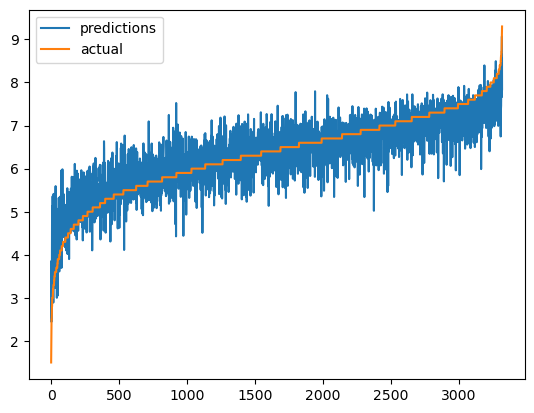

In [7]:
# Create a dataframe for the actual and prediction values
test_compare = pd.DataFrame({'orig_index':y_test_rf.index, 'actual':y_test_rf.values})
test_compare['predictions'] = rating_predictions
test_compare = test_compare.sort_values('actual').reset_index(drop=True)

# Plot the dataframe
test_lines = test_compare[['predictions', 'actual']].plot.line()

## Plot the Training predictions and actuals together

In [8]:
# Check the model against the training data - if mse is much lower than the model is overfitting
y_train_pred = rf_model_rating.predict(X_train_rf)
mse_train = mean_squared_error(y_train_rf, y_train_pred)
mse_train

0.02916691498639883

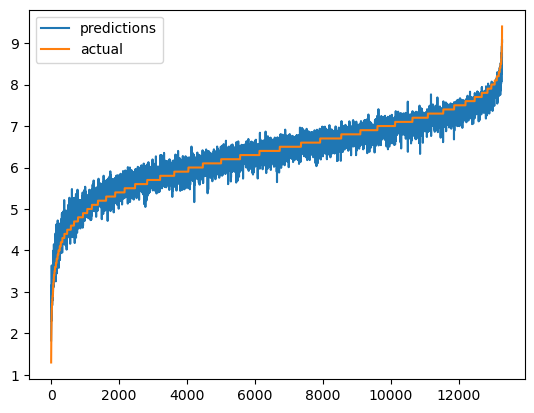

In [9]:
# Create a dataframe for the actual and prediction values
train_compare = pd.DataFrame({'orig_index':y_train_rf.index, 'actual':y_train_rf.values})
train_compare['predictions'] = y_train_pred
train_compare = train_compare.sort_values('actual').reset_index(drop=True)

# Plot the dataframe
train_lines = train_compare[['predictions', 'actual']].plot.line()

# Applying Keras Tuner

## Convert categorical data into dummy columns for Keras Tuner

In [10]:
df_rating = pd.get_dummies(data=df_rating, columns=['genres', 'OMDB_Rated'])
df_rating.head()

,Writer_Avg_Rating,Director_Avg_Rating,Actor_Avg_Rating,runtimeMinutes,OMDB_Metascore,ReleaseMonth,averageRating,genres_Action,genres_Adult,genres_Comedy,...,genres_Mystery,genres_N,genres_Romance,genres_Sci-Fi,genres_Thriller,genres_Western,OMDB_Rated_adults,OMDB_Rated_kids,OMDB_Rated_teens,OMDB_Rated_unknown
33,7.03,7.36,6.61,77.0,79.0,4.0,7.4,0,0,0,...,0,0,0,0,0,0,0,1,0,0
54,6.22,5.90,6.25,90.0,40.0,8.0,6.0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
65,6.04,6.20,6.09,114.0,61.0,10.0,5.4,0,0,0,...,0,0,0,0,0,0,0,0,0,1
86,5.80,5.80,5.92,105.0,43.0,9.0,5.8,0,0,0,...,0,0,0,0,0,0,1,0,0,0
133,5.77,5.45,6.03,91.0,47.0,8.0,5.5,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## Split the data into training and test sets

In [11]:
# Define features as X, target as y
y = df_rating['averageRating']
X = df_rating.drop(columns='averageRating')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Scale the data

In [12]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Define the keras tuner behavior and execute

In [13]:
# Define the keras tuner parameters
def create_model(hp):
    movie_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])

    # Allow kerastuner to decide which optimizer
    optimizer = hp.Choice('opt', values=['adam', 'sgd', 'rmsprop'])
    
    # Allow kerastuner to decide number of neurons in first layer
    movie_model.add(tf.keras.layers.Dense(units=hp.Int('first_units', min_value=1, max_value=10, step=2), 
                                          activation=activation, input_dim=24))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        movie_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=10,
            step=2),
            activation=activation))

    movie_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # Compile the model
    movie_model.compile(loss="mse", optimizer=optimizer, metrics=[tf.keras.metrics.MeanSquaredError()])

    return movie_model

In [14]:
tuner = kt.Hyperband(
    create_model,
    objective="val_loss",
    max_epochs=20,
    hyperband_iterations=2, 
    project_name='movie_viewers')

In [15]:
# Grab start time
start_time = time.time()

# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

# Print time taken
print("--- %s minutes ---" % round(((time.time() - start_time)/60),2))

# 181k rows, 22 dimensions = 104 minutes

Trial 60 Complete [00h 00m 13s]
val_loss: 29.40654182434082

Best val_loss So Far: 29.406538009643555
Total elapsed time: 00h 05m 55s
--- 5.92 minutes ---


In [16]:
# Get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

{'activation': 'relu',
 'opt': 'rmsprop',
 'first_units': 9,
 'num_layers': 3,
 'units_0': 5,
 'units_1': 5,
 'units_2': 9,
 'units_3': 1,
 'units_4': 3,
 'units_5': 5,
 'tuner/epochs': 3,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 2,
 'tuner/round': 0}

In [17]:
# Evaluate best model against full test data
best_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, MSE: {model_accuracy}")

104/104 - 0s - loss: 29.4065 - mean_squared_error: 29.4065 - 150ms/epoch - 1ms/step
Loss: 29.406538009643555, MSE: 29.406538009643555


In [18]:
# Check the model against the training data - if mse is much lower than the model is overtraining
model_loss_train, model_accuracy_train = best_model.evaluate(X_train_scaled,y_train,verbose=2)
print(f"Loss: {model_loss_train}, MSE: {model_accuracy_train}")

415/415 - 0s - loss: 29.4719 - mean_squared_error: 29.4719 - 343ms/epoch - 827us/step
Loss: 29.471920013427734, MSE: 29.471920013427734


In [19]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9)                 225       
                                                                 
 dense_1 (Dense)             (None, 5)                 50        
                                                                 
 dense_2 (Dense)             (None, 5)                 30        
                                                                 
 dense_3 (Dense)             (None, 9)                 54        
                                                                 
 dense_4 (Dense)             (None, 1)                 10        
                                                                 
Total params: 369 (1.44 KB)
Trainable params: 369 (1.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Create, Train, and Evaluate a Model based on Keras Tuner Output Using More Epochs

In [27]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=9, activation="relu", input_dim=24))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=5, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=5, activation="relu"))

# Fourth hidden layer
nn.add(tf.keras.layers.Dense(units=9, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="relu"))

# Check the structure of the model
nn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 9)                 225       
                                                                 
 dense_10 (Dense)            (None, 5)                 50        
                                                                 
 dense_11 (Dense)            (None, 5)                 30        
                                                                 
 dense_12 (Dense)            (None, 9)                 54        
                                                                 
 dense_13 (Dense)            (None, 1)                 10        
                                                                 
Total params: 369 (1.44 KB)
Trainable params: 369 (1.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
# Grab start time
start_time = time.time()

# Compile the model 
nn.compile(loss="mse", optimizer="rmsprop", metrics=[tf.keras.metrics.MeanSquaredError()])

# Train the model over 100 epochs
fit_model = nn.fit(X_train_scaled, y_train, epochs=100)

# Print time taken
print("--- %s minutes ---" % round(((time.time() - start_time)/60),2))

Epoch 1/100
415/415 [==============================] - 1s 1ms/step - loss: 14.5418 - mean_squared_error: 14.5418
Epoch 2/100
415/415 [==============================] - 1s 1ms/step - loss: 0.4497 - mean_squared_error: 0.4497
Epoch 3/100
415/415 [==============================] - 1s 1ms/step - loss: 0.2745 - mean_squared_error: 0.2745
Epoch 4/100
415/415 [==============================] - 1s 1ms/step - loss: 0.2502 - mean_squared_error: 0.2502
Epoch 5/100
415/415 [==============================] - 1s 1ms/step - loss: 0.2400 - mean_squared_error: 0.2400
Epoch 6/100
415/415 [==============================] - 1s 1ms/step - loss: 0.2343 - mean_squared_error: 0.2343
Epoch 7/100
415/415 [==============================] - 1s 1ms/step - loss: 0.2315 - mean_squared_error: 0.2315
Epoch 8/100
415/415 [==============================] - 1s 1ms/step - loss: 0.2286 - mean_squared_error: 0.2286
Epoch 9/100
415/415 [==============================] - 1s 1ms/step - loss: 0.2257 - mean_squared_error: 0.2257

In [29]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

104/104 - 0s - loss: 0.2168 - mean_squared_error: 0.2168 - 264ms/epoch - 3ms/step
Loss: 0.21681563556194305, Accuracy: 0.21681563556194305


# Export the Random Forest Results

In [23]:
print(f'rf_df_rating length: {len(rf_df_rating)}')
print(f'rf_df_rating columns: {len(rf_df_rating.columns)}')
print(f'test_compare length: {len(test_compare)}')
print(f'test_compare columns: {len(test_compare.columns)}')
print(f'train_compare length: {len(train_compare)}')
print(f'train_compare columns: {len(train_compare.columns)}')

rf_df_rating length: 16594
rf_df_rating columns: 9
test_compare length: 3319
test_compare columns: 3
train_compare length: 13275
train_compare columns: 3


In [24]:
predict_compare = pd.concat([test_compare, train_compare])
print(f'predict_compare length: {len(predict_compare)}')
predict_compare.head(2)

predict_compare length: 16594


,orig_index,actual,predictions
0,189744,1.5,3.258333
1,57939,1.9,2.899000


In [25]:
user_movie_predictions = rf_df_rating.merge(predict_compare, left_on=rf_df_rating.index, right_on='orig_index')
user_movie_predictions = user_movie_predictions.drop(columns='orig_index')
user_movie_predictions

,Writer_Avg_Rating,Director_Avg_Rating,Actor_Avg_Rating,runtimeMinutes,OMDB_Metascore,genres,OMDB_Rated,ReleaseMonth,averageRating,actual,predictions
0,7.03,7.36,6.61,77.0,79.0,3,1,4.0,7.4,7.4,7.278667
1,6.22,5.90,6.25,90.0,40.0,12,0,8.0,6.0,6.0,6.008667
2,6.04,6.20,6.09,114.0,61.0,6,3,10.0,5.4,5.4,5.734000
3,5.80,5.80,5.92,105.0,43.0,6,0,9.0,5.8,5.8,5.814333
4,5.77,5.45,6.03,91.0,47.0,2,2,8.0,5.5,5.5,5.704000
...,...,...,...,...,...,...,...,...,...,...,...
16589,6.90,6.90,6.90,96.0,58.0,3,2,4.0,6.9,6.9,6.905000
16590,7.20,7.65,7.64,92.0,58.0,3,1,9.0,7.2,7.2,7.310000
16591,6.70,6.70,6.51,85.0,77.0,4,3,6.0,6.7,6.7,6.701667
16592,5.40,5.40,5.82,90.0,31.0,6,2,10.0,5.4,5.4,5.369333


In [26]:
user_movie_predictions.to_csv("../Resources/movie_viewers_model_results.csv")